In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas as pd 
import os
from src.nn.nn_dataset import DataSampler
from src.functions import *
from src.nn.nn_actions import NeuralNetworkActions
from omegaconf import OmegaConf
import wandb

%load_ext autoreload
%autoreload 2


In [18]:
cfg = OmegaConf.load("src/conf/setup_dataset_nn.yaml")
cfg.dataset.transform_input = "None"
cfg.dataset.transform_output = "None"
cfg.nn.update_weight_method = "Static"
cfg.nn.optimizer = "Adam"
cfg.nn.type = "DynamicNN"
cfg.model.model_flag = "SM_AVR_GOV"
cfg.dataset.number = 1
if cfg.nn.optimizer == "LBFGS":
    cfg.nn.num_epochs = int(cfg.nn.num_epochs /40)
network2 = NeuralNetworkActions(cfg)
#network.load_model("data\model_10000_5000_300_53_1_0_0.pth")


num_of_data = 4000000
num_of_skip_data_points = 53
num_of_skip_col_points = 5
num_of_skip_val_points = 4
weight_data = 0
weight_dt = 0
weight_pinn = 1e-4

network2.pinn_train( weight_data, weight_dt, weight_pinn, num_of_data, num_of_skip_data_points, num_of_skip_col_points, num_of_skip_val_points)


Loading data from:  data\SM_AVR_GOV/dataset_v3.pkl
Number of training samples:  160000 Number of validation samples:  20000 Number of testing samples:  20000
Number of different initial conditions for collocation points:  200
[[-2, 2], [-0.2, 0.2], [0], [0, 2], [1, 1.05], [1.105], [1.08], [0.7048], [0.7048]] Set of values for init conditions
[10, 10, 1, 2, 1, 1, 1, 1, 1] Iterations per value
src/conf/params\system1.yaml
Number of labeled training data:  3019  number of collocation points:  40000  number of validation data:  5000  number of collocation points ic:  200
Validation loss decreased (inf --> 4.808262).  Saving model ...
Epoch [50/10000], Loss: 0.0523, Loss_data: 2.3687, Loss_dt: 66.1496, Loss_pinn: 204.2258 , Loss_pinn_ic : 0.0319 [0.001] 2.187404155731201
Epoch [100/10000], Loss: 0.0346, Loss_data: 2.3620, Loss_dt: 66.2251, Loss_pinn: 235.6338 , Loss_pinn_ic : 0.0110 [0.001] 2.1923749446868896
Early stopping
Validation loss decreased (4.808262 --> 2.183434).  Saving model ..

DynamicNN
None


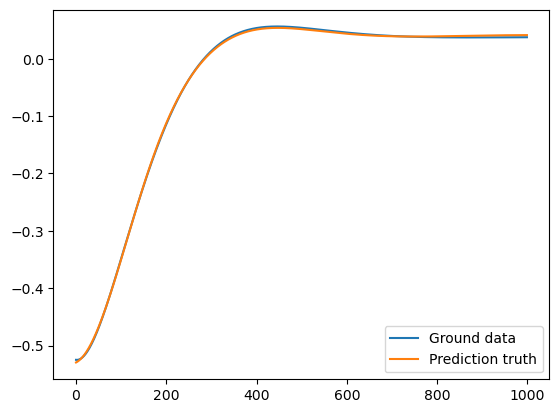

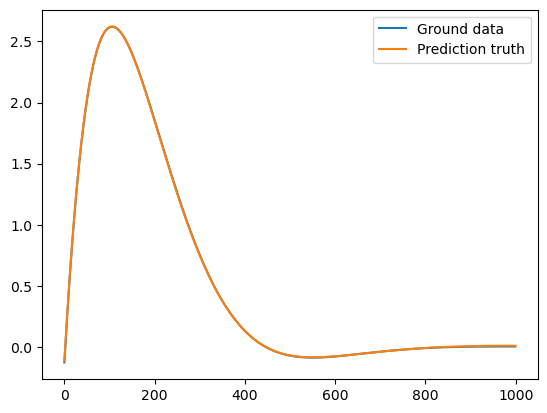

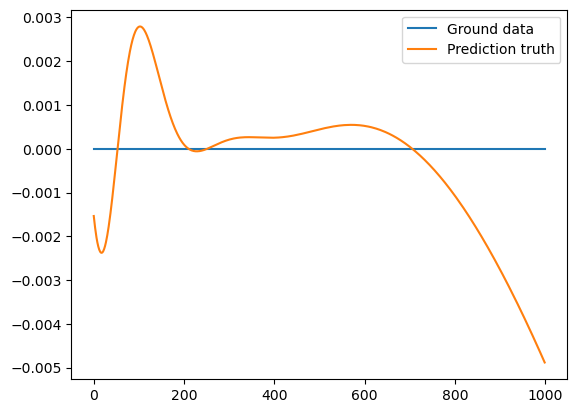

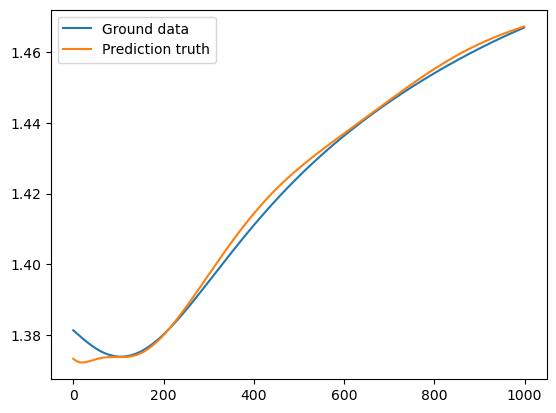

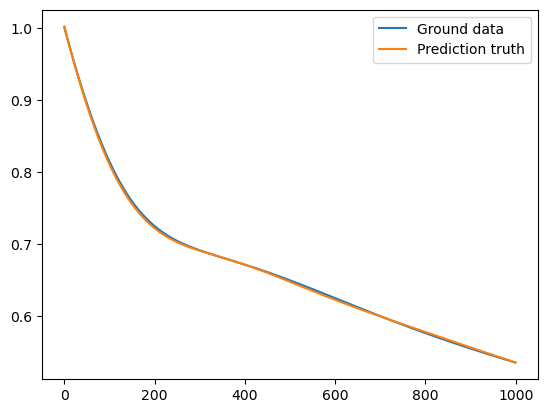

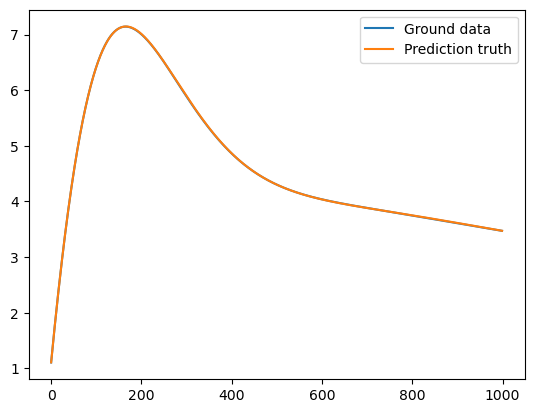

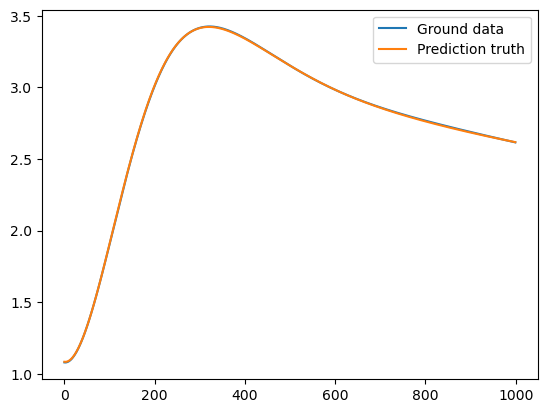

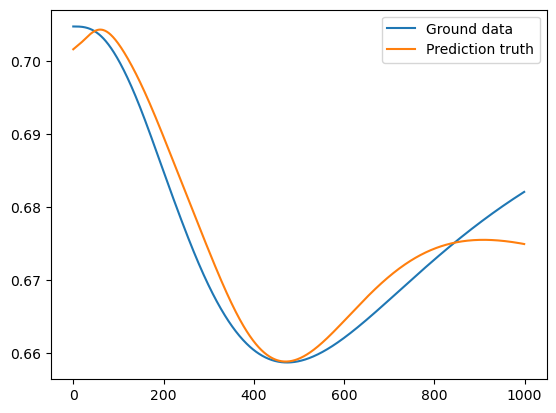

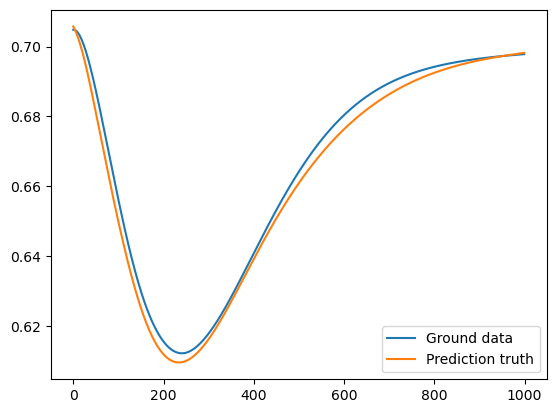

In [34]:
sample_per_traj = 1000
starting_traj = 1
total_traj = 10
x_test = network2.data_loader.x_test[starting_traj*sample_per_traj:(starting_traj+total_traj)*sample_per_traj].clone().detach().to(network2.device).requires_grad_(True)
y_test = network2.data_loader.y_test[starting_traj*sample_per_traj:(starting_traj+total_traj)*sample_per_traj].clone().detach().to(network2.device)
network2.model.eval()
x_test = network2.transform_input(x_test)

y_test_old = y_test.clone().detach()
##y_test = network.data_loader.adjust_target(x_test, y_test)
y_pred = network2.forward_pass(x_test)
#y_pred0 = network.forward_pass(x_test)
y_test_old = network2.transform_output(y_test_old)
print(network2.cfg.nn.type)
print(network2.cfg.dataset.transform_input)
loss = network2.criterion(y_pred, y_test_old)

limit = sample_per_traj*1

for var in range(y_test.shape[1]):
    plt.plot(y_test_old[:limit,var].cpu().detach().numpy(), label='Ground data')
    plt.plot(y_pred[:limit,var].cpu().detach().numpy(), label='Prediction truth')
    #plt.plot(y_pred0[:limit,var].cpu().detach().numpy(), label='Prediction truth more data')
    #plt.plot(y_pred_old1[:limit,var].cpu().detach().numpy(), label='Prediction truth only data')
    plt.legend()
    plt.show()



In [32]:
network2.test_model( starting_traj=0, total_traj=50)

Total test trajectories 20
Loss: 0.00021075
MAE Loss: 0.01010371


0.00021074946562293917